In [98]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.cross_validation import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from src.NNmodel import NN_with_CategoryEmbedding as NN
from src.telstra_data import TelstraData, multiclass_log_loss
from matplotlib import pyplot as plt
from scipy.optimize import minimize

This notebook will show the neural net and xgboost models I used, as well as the code for combining different models' predictions into a final submission.

## Neural network models

Here is the configuration of a NN model I used for the final submission. Model code can be found in [`src/NNmodel.py`](https://github.com/gereleth/kaggle-telstra/blob/master/src/NNmodel.py). It was adapted from [@entron's code](https://www.kaggle.com/c/rossmann-store-sales/forums/t/17974/code-sharing-3rd-place-category-embedding-with-deep-neural-network/103140#post103140) for neural networks with category embedding from Rossmann competition. Parameters were tuned with hyperopt. Two more model configurations that achieve similar performance are at the end of the notebook.

In [23]:
featureparams = {"location_min_count": 0,
                 "n_common_events":-1, # use all
                 "n_common_log_features":320,
                 "n_common_resources":-1}
aggregateparams = {"loc_agg_prior_weight":1.0}
modelparams = {'dense_1_size': 139,
              'dense_2_size': 85,
              'dense_3_size':0,
              'dropout_1': 0.33518161422102916,
              'dropout_2': 0.11022698073986464,
              'dropout_3': 0.10,
              'events_model_l1': 0.0828912773683751,
              'events_model_l2': 0.09058440269409214,
              'events_model_size': 36,
              'location_embedding_l1': 152.047625356857,
              'location_embedding_l2': 0.005514020843033711,
              'location_embedding_size': 989,
              'log_model_l1': 0.0009942575290641173,
              'log_model_l2': 0.0065254811643931775,
              'log_model_size': 209,
              'resource_model_l1': 0.17048437747361556,
              'resource_model_l2': 0.0018463316856817326,
              'resource_model_size': 6,
              'rest_model_l1': 0.00013833756522212644,
              'rest_model_l2': 0.00032397510167688485,
              'rest_model_size': 16,
              'severity_embedding_l1': 0.0004075447695903401,
              'severity_embedding_l2': 0.006030296208917552,
              'severity_embedding_size': 2}
nb_epoch = 65

Load training data

In [6]:
data = TelstraData(**featureparams)
pred_cols = ['predict_{}'.format(i) for i in range(3)]
y = data.get_y()

Split data into train and validation portions. I'll only use a single holdout set here to save some time.

In [24]:
kf = StratifiedKFold(y.values, n_folds=8, shuffle=True, random_state = 3)
for itrain, itest in kf:
    Xtr, ytr, Xte, yte = data.get_train_test_features(itrain, itest, **aggregateparams)
    break

/home/daria/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:993: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)


Fit NN model on train portion and evaluate on validation portion.

In [25]:
model = NN(modelparams)
history = model.fit(Xtr, ytr.astype(int).values, nb_epoch = nb_epoch)
nnpred = pd.DataFrame(model.predict_proba(Xte), index = yte.index, columns = pred_cols)
loss = multiclass_log_loss(yte, nnpred.values)
print('Validation set mlogloss = {:.5f}'.format(loss))

Validation set mlogloss = 0.46061


Let's fit 9 more NNmodels to the same training data and look at how performance changes if we take an average of predictions from n models.

In [26]:
nnpreds = [nnpred]
for i in range(1,10):
    model = NN(modelparams)
    history = model.fit(Xtr, ytr.astype(int).values, nb_epoch = nb_epoch)
    nnpred = pd.DataFrame(model.predict_proba(Xte), index = yte.index, columns = pred_cols)
    loss = multiclass_log_loss(yte, nnpred.values)
    nnpreds.append(nnpred)
    ensemble_loss = multiclass_log_loss(yte, (sum(nnpreds)/len(nnpreds)).values)
    print('Model {} validation set mlogloss = {:.5f}, ensemble mlogloss = {:.5f}'.format(i+1,loss, ensemble_loss))

Model 2 validation set mlogloss = 0.47030, ensemble mlogloss = 0.45781
Model 3 validation set mlogloss = 0.47501, ensemble mlogloss = 0.45684
Model 4 validation set mlogloss = 0.46910, ensemble mlogloss = 0.45567
Model 5 validation set mlogloss = 0.47573, ensemble mlogloss = 0.45649
Model 6 validation set mlogloss = 0.46792, ensemble mlogloss = 0.45369
Model 7 validation set mlogloss = 0.46394, ensemble mlogloss = 0.45248
Model 8 validation set mlogloss = 0.46153, ensemble mlogloss = 0.45101
Model 9 validation set mlogloss = 0.47278, ensemble mlogloss = 0.45091
Model 10 validation set mlogloss = 0.46560, ensemble mlogloss = 0.45055


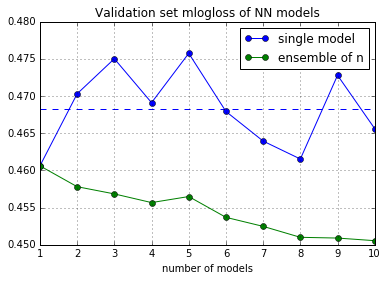

In [41]:
nn_single_model_loss = [multiclass_log_loss(yte, p.values) for p in nnpreds]
nn_ensemble_loss = []
for i in range(len(nnpreds)):
    enspred = sum(nnpreds[:i+1])/(i+1)
    nn_ensemble_loss.append(multiclass_log_loss(yte, enspred.values))
fig, ax = plt.subplots()
ax.plot(np.arange(10)+1,nn_single_model_loss,'o-')
ax.plot(np.arange(10)+1,nn_ensemble_loss,'o-')
ax.hlines(np.mean(nn_single_model_loss),1,10,colors='b',linestyles='dashed')
ax.legend(['single model', 'ensemble of n'],loc='upper right')
ax.grid()
ax.set_xlabel('number of models')
ax.set_title('Validation set mlogloss of NN models');

In the plot above we can see how ten NN models with an average score of 0.468 (dashed line) give a 0.451 score when combined. I observed the same effect when doing CV on the whole training set - ten models of 0.460 would combine into one of 0.445.

## XGB models

Here are the configurations of six xgb models that went into my final submission. Let's fit them to our training data and evaluate validation performance.

In [63]:
commonparams = {'eval_metric': 'mlogloss', 
                'max_delta_step': 1, 
                'objective': 'multi:softprob', 
                'silent': 1, 
                'num_class': 3}

In [74]:
xgbparams = [{'alpha': 9.070509594630558e-05,
  'colsample_bytree': 0.8972541420793363,
  'eta': 0.01502700272070676,
  'lambda': 83.05282248672957,
  'max_depth': 17.0,
  'subsample': 0.5349534042968074},
 {'alpha': 4.683734619799559e-05,
  'colsample_bytree': 0.5256667987490449,
  'eta': 0.030280365635423655,
  'lambda': 133.0395353323493,
  'max_depth': 14.0,
  'subsample': 0.31360418453779687},
 {'alpha': 0.0031639363875188785,
  'colsample_bytree': 0.5323284110284611,
  'eta': 0.0230140072243492,
  'lambda': 324.8350511121133,
  'max_depth': 14,
  'subsample': 0.7801747377178474},
 {'alpha': 0.0003370723167958087,
  'colsample_bytree': 0.34693769396886787,
  'eta': 0.026673988051864925,
  'lambda': 31.087281466818265,
  'max_depth': 29.0,
  'subsample': 0.322428925517773},
 {'alpha': 0.0005973413827509292,
  'colsample_bytree': 0.8730396289388369,
  'eta': 0.03603156818614976,
  'lambda': 16.76076386621095,
  'max_depth': 14.0,
  'subsample': 0.489741772820973},
 {'alpha': 0.0007008911010374653,
  'colsample_bytree': 0.4240562779860287,
  'eta': 0.01654419336572982,
  'lambda': 115.36267040519867,
  'max_depth': 14.0,
  'subsample': 0.6039677499529313}]

In [65]:
numtrees = [1246, 1757, 2426, 769, 315, 1958]

In [68]:
featureparams = {'location_min_count': 0,
 'n_common_events': 20,
 'n_common_log_features': 60,
 'n_common_resources': 10,
 'n_label_encoded_log_features': 4}
aggregateparams = {"loc_agg_prior_weight":3.0}

I reload the data, because features are different between NNs and tree-based models.

In [69]:
data = TelstraData(**featureparams)
Xtr, ytr, Xte, yte = data.get_train_test_features(itrain, itest,**aggregateparams)

In [77]:
dtrain = xgb.DMatrix(Xtr, ytr)
dtest = xgb.DMatrix(Xte)

In [87]:
xgbpreds = []
xgb_single_model_loss = []
xgb_ensemble_loss = []
i=0
for clfparams, num_rounds in zip(xgbparams, numtrees):
    clfparams.update(commonparams)
    gbm = xgb.train(clfparams, dtrain, num_rounds)
    xgbpred = pd.DataFrame(gbm.predict(dtest).reshape(yte.shape[0],len(pred_cols)),
                            index = yte.index, columns = pred_cols)
    loss = multiclass_log_loss(yte, xgbpred.values)
    xgbpreds.append(xgbpred)
    xgb_single_model_loss.append(loss)
    ensemble_loss = multiclass_log_loss(yte, (sum(xgbpreds)/len(xgbpreds)).values)
    xgb_ensemble_loss.append(ensemble_loss)
    i+=1
    print('XGB model {} validation set mlogloss = {:.5f}, ensemble mlogloss = {:.5f}'.format(i,loss, ensemble_loss))

XGB model 1 validation set mlogloss = 0.43935, ensemble mlogloss = 0.43935
XGB model 2 validation set mlogloss = 0.44199, ensemble mlogloss = 0.43967
XGB model 3 validation set mlogloss = 0.44466, ensemble mlogloss = 0.44064
XGB model 4 validation set mlogloss = 0.43774, ensemble mlogloss = 0.43898
XGB model 5 validation set mlogloss = 0.44071, ensemble mlogloss = 0.43844
XGB model 6 validation set mlogloss = 0.44141, ensemble mlogloss = 0.43880


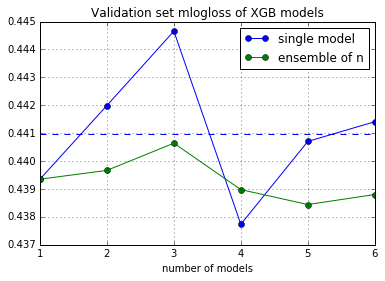

In [88]:
fig, ax = plt.subplots()
ax.plot(np.arange(6)+1,xgb_single_model_loss,'o-')
ax.plot(np.arange(6)+1,xgb_ensemble_loss,'o-')
ax.hlines(np.mean(xgb_single_model_loss),1,6,colors='b',linestyles='dashed')
ax.legend(['single model', 'ensemble of n'],loc='upper right')
ax.grid()
ax.set_xlabel('number of models')
ax.set_title('Validation set mlogloss of XGB models');

XGB models have better performance, but contrary to the neural net models they do not benefit much from blending.

## More models into the mix

Let's throw in some RF and ET models for good measure.

In [91]:
rf = RandomForestClassifier(n_estimators = 400, min_samples_leaf=3, max_features=20, random_state=1)
rf.fit(Xtr, ytr)
rfpred = pd.DataFrame(rf.predict_proba(Xte),index = yte.index, columns = pred_cols)
multiclass_log_loss(yte.values, rfpred.values)

0.44588335947564389

In [93]:
et = ExtraTreesClassifier(n_estimators = 400, random_state=1)
et.fit(Xtr, ytr)
etpred = pd.DataFrame(et.predict_proba(Xte),index = yte.index, columns = pred_cols)
multiclass_log_loss(yte.values, etpred.values)

0.43957680347939809

## Blending

So now we have predictions of 4 models on our holdout set. Let's try blending them to get an idea of what improvement might be gained.

In [94]:
# take average predictions from models of each class
nnpred = sum(nnpreds)/len(nnpreds)
xgbpred = sum(xgbpreds)/len(xgbpreds)

Let's try giving each model equal weights:

In [95]:
blend1 = 0.25*(nnpred+xgbpred+rfpred+etpred)
multiclass_log_loss(yte.values, blend1.values)

0.4241682934794524

Not bad, we went from 0.439 as the best score to 0.424 by combining predictions from all models.

Still, it seems like we could adjust the blending coefficients to push the score further down. Blending coefficients should be nonnegative and sum to one. I didn't know how to do such constrained optimisation. But then I realized we can turn it into an unconstrained optimisation by applying the softmax function. Here is the function I used for creating blending weights:

In [103]:
def optimize_weights(preds, y):
    def mlogloss(x):
        weights = np.exp(x)/np.sum(np.exp(x))
        pred = sum([p*w for (p,w) in zip(preds,weights)])
        return multiclass_log_loss(y.values, pred.values)
    res = minimize(mlogloss, np.zeros(len(preds)))
    w = np.exp(res.x)/np.sum(np.exp(res.x))
    return w

Let's apply it to our models' predictions and see what we get:

In [104]:
preds = [nnpred, xgbpred, rfpred, etpred]
models = ['nn','xgb','rf','et']
weights = optimize_weights(preds,yte)

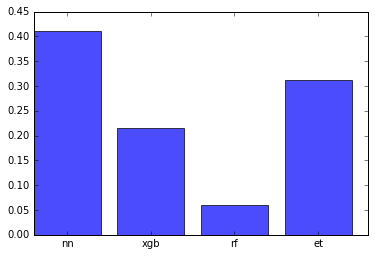

In [108]:
plt.bar(np.arange(len(weights)),weights, alpha = 0.7)
plt.xticks(np.arange(len(weights)) + 0.4, models);

It's interesting how NN models, despite having the highest loss, receive a high weight. I think this is probably because they are of a different class than the other models which are all tree-based.

What is our score now?

In [109]:
blend2 = sum([p*w for (p,w) in zip(preds,weights)])
multiclass_log_loss(yte.values, blend2.values)

0.42193252815598697

By adjusting the weights we've been able to push mlogloss a bit further down, to 0.422.

Here are the weights I got from doing the same procedure on out-of-fold predictions from 6 models I made for this competition:

![](https://www.dropbox.com/s/52kywr50dwsim2b/p8.png?dl=1)

Here random forest and extra trees models received very low weights and were effectively rejected in favour of their refined counterparts. Interesting that the proportions of nn/tree-based models are the same in two plots.

Try this method for your own predictions, and let me know if you can improve it =).

## Appendix: additional NN configurations

In [ ]:
modelparams = {'dense_1_size': 126,
  'dense_2_size': 342,
  'dropout_1': 0.08099249518461987,
  'dropout_2': 0.11546789274740131,
  'events_model_l1': 136.5688610112883,
  'events_model_l2': 0.03521377522651845,
  'events_model_size': 33,
  'location_embedding_l1': 0.05243945780052779,
  'location_embedding_l2': 0.5230097653586395,
  'location_embedding_size': 994,
  'log_model_l1': 0.0025618283149878083,
  'log_model_l2': 0.027193056421825925,
  'log_model_size': 265,
  'resource_model_l1': 0.06763728965163812,
  'resource_model_l2': 0.09873407984707304,
  'resource_model_size': 6,
  'rest_model_l1': 0.006660825957147594,
  'rest_model_l2': 0.09454134206291084,
  'rest_model_size': 16,
  'severity_embedding_l1': 0.00867032801435,
  'severity_embedding_l2': 10.0636380379717,
  'severity_embedding_size': 10}

In [ ]:
modelparams = {'dense_1_size': 80,
  'dense_2_size': 346,
  'dropout_1': 0.0858925099124953,
  'dropout_2': 0.2369274970643942,
  'events_model_l1': 2754.4532286151884,
  'events_model_l2': 0.02504414214050731,
  'events_model_size': 23,
  'location_embedding_l1': 0.007541470559434677,
  'location_embedding_l2': 0.012919951657518426,
  'location_embedding_size': 922,
  'log_model_l1': 0.0011872122210382751,
  'log_model_l2': 0.02351141159862712,
  'log_model_size': 352,
  'resource_model_l1': 0.38902261977393804,
  'resource_model_l2': 0.05837733528316206,
  'resource_model_size': 7,
  'rest_model_l1': 0.0045845583781958,
  'rest_model_l2': 0.15940253898596193,
  'rest_model_size': 30,
  'severity_embedding_l1': 0.0018053162894629338,
  'severity_embedding_l2': 0.0048684863282926925,
  'severity_embedding_size': 9}